# The goal of this notebook is to wire up evaluation from the MADE challenge using BIOC files

In [1]:
import os
import json
import random
import pickle
import string
from collections import Counter
import glob
import time
import subprocess
import datetime

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

import nltk

import joblib

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

gensim.__version__

'4.3.2'

In [4]:
import bioc
from bioc import biocxml

from bioc_evaluation import get_f_scores

In [5]:
import sklearn
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, ParameterGrid
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

import sklearn_crfsuite
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite import metrics

In [6]:
import basic
from basic.nlp.tokenizers import clinical_tokenizers
from basic.nlp.annotation.annotation import Annotation, AnnotatedDocument
from basic.nlp.sequenceutils import get_sentence_bio_tagged_tokens

from madetokenizer import build_made_tokenizer
from madeutils import read_made_data, get_all_sentence_tokens_and_tags, gather_validation_metrics
from madeutils import get_coarse_labels, evaluate_via_bioc, plot_confusion_matrix

print('Imported custom BASIC modules')

Imported custom BASIC modules


In [7]:
%time nltk.download('averaged_perceptron_tagger')

CPU times: total: 62.5 ms
Wall time: 232 ms


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aaa4026\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
MADE_ALL_SETS_BASE_DIR = r'C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE'
MADE_BASE_DIR = r'{0}\MADE-data\MADE-1.0'.format(MADE_ALL_SETS_BASE_DIR)
PREDICTION_DIR = 'predictions'

In [9]:
CLUSTERS_BASE_DIR = r'resources/clusters'

In [10]:
MEDEX_DIR = r'resources/medex'
drug_term_file = 'medex_filtered_terms.txt'
drug_term_path = os.path.join(MEDEX_DIR, drug_term_file)

In [11]:
# let's also load and test a Brill Part of Speech tagger which was trained on the Penn Treebank:
BRILL_TAGGER_FILE_PATH = 'resources/pos/treebank_brill_aubt.pickle'
brill_tagger = pickle.load(open(BRILL_TAGGER_FILE_PATH, 'rb'))
print(brill_tagger)

# now let's kick the tires on this tagger
test_tag_tokens = 'The cat walked onto an airplane'.split()
print(brill_tagger.tag(test_tag_tokens))

[('The', 'DT'), ('cat', '-None-'), ('walked', 'VBD'), ('onto', 'IN'), ('an', 'DT'), ('airplane', 'NN')]


In [12]:
MAX_SENTENCE_LENGTH = 50

# Let's load in the original training test split

In [13]:
made_tokenizer = build_made_tokenizer()
annotated_docs = read_made_data(MADE_BASE_DIR, made_tokenizer)

print('Total Annotated Docs : {}'.format(len(annotated_docs)))

Building MADE tokenizer...
('.', '!')
Compiled 8 total preprocessing regular expressions
Total annotated documents loaded : 876
Total Annotated Docs : 876


In [14]:
RANDOM_STATE = 777

# To evaluate properly, we need to split apart by documents first so that we have the ability to track tokens

In [15]:
train_docs, test_docs = sklearn.model_selection.train_test_split(annotated_docs, train_size=0.8, random_state=RANDOM_STATE)
print('Total training documents : {}'.format(len(train_docs)))
print('Total test documents : {}'.format(len(test_docs)))

Total training documents : 700
Total test documents : 176


In [16]:
%%time

# now let' pile up all of our documents and split them into an initial fold
print('Fetching tokens and tags...')
X_train, y_train = get_all_sentence_tokens_and_tags(train_docs)
X_test, y_test = get_all_sentence_tokens_and_tags(test_docs)
print('DONE Fetching tokens and tags')

Fetching tokens and tags...
DONE Fetching tokens and tags
CPU times: total: 3.81 s
Wall time: 4.19 s


In [17]:
class CRFExtractor(object):
    def __init__(self,
                 window_size = 2,
                 char_ngrams_enabled = set([2, 3]),
                enable_stem_features = False,
                enable_pos_features = False,
                 enable_lexical_features = True,
                pos_tagger = None,
                word_cluster_map_tuples = [],
                enable_sentence_window_clusters = False,
                enable_local_window_clusters = False,
                 enable_cluster_bigrams = False,
                drug_term_set = set(),
                enable_drug_term_features = False):
        print('Creating CRFExtractor')
        self.window_size = window_size
        self.char_ngrams_enabled = char_ngrams_enabled
        self.enable_stem_features = enable_stem_features
        self.enable_pos_features = enable_pos_features
        self.enable_lexical_features = enable_lexical_features
        self.pos_tagger = pos_tagger
        self.word_cluster_map_tuples = word_cluster_map_tuples
        self.enable_sentence_window_clusters = enable_sentence_window_clusters
        self.enable_local_window_clusters = enable_local_window_clusters
        self.enable_cluster_bigrams = enable_cluster_bigrams
        self.drug_term_set = drug_term_set
        self.enable_drug_term_features = enable_drug_term_features
        
        # this is used to collect drug terms found
        self.found_drug_term_set = set()
        
        print('Total word maps loaded : {}'.format(len(self.word_cluster_map_tuples)))
        print('Character ngrams enabled : {}'.format(str(char_ngrams_enabled)))
        
    def add_sentence_window_clusters(self, feature_prefix, tokens, features, cluster_mapping_tokens_map):
        if len(self.word_cluster_map_tuples) == 0:
            return
        
        # iterate through the list of mappings already computed
        for map_prefix, token_clusters in cluster_mapping_tokens_map.items():
            # loop through each token in the window and add a one-hot value for each cluster mapped
            for cluster_mapping in token_clusters:
                if cluster_mapping is not None:
                    # feature name should include which direction (left/right) and which clusters were found
                    cluster_feature_name = '{0}_{1}_CL_{2}'.format(feature_prefix, map_prefix, str(cluster_mapping))
                    features[cluster_feature_name] = True
                    
    def add_drug_window_features(self, feature_prefix, tokens, features):
        found_in_window = False
        for token in tokens:
            # drug set is all lowercase
            token_lower = token.lower()
            if token_lower in self.drug_term_set:
                found_in_window = True
                self.found_drug_term_set.add(token_lower)
                break
                
        if found_in_window:
            drug_feature_name = 'D_{0}'.format(feature_prefix)
            features[drug_feature_name] = True
        
    def add_local_window_cluster(self, prefix, token_idx, features, cluster_mapping_tokens_map):
        if len(self.word_cluster_map_tuples) == 0:
            return
        
        # iterate through the list of mappings already computed
        for map_prefix, token_clusters in cluster_mapping_tokens_map.items():
            cluster_mapping = token_clusters[token_idx]
            if cluster_mapping is not None:
                # feature name should include the position 
                cluster_feature_name = '{0}_{1}_CL'.format(prefix, map_prefix)
                # and then the value will be the categorical cluster value
                features[cluster_feature_name] = str(cluster_mapping)
                
    def add_cluster_bigrams(self, i, cluster_tokens_map, features):
        # for each map, let's work over each window
        for cluster_prefix, token_mappings in cluster_tokens_map.items():
            # work across the window
            for window_idx in range(-1 * self.window_size, self.window_size + 1):
                # make sure that we do not go out of bounds
                token_a_idx = i + window_idx
                token_b_idx = i + window_idx + 1
                if token_a_idx < 0 or token_b_idx >= len(token_mappings):
                    continue
                
                #print('Working on token index {0}'.format(curr_token_idx))
                token_a_prefix = str(window_idx)
                token_b_prefix = str(window_idx + 1)
                
                feature_name = '{0}_G_{1}_{2}'.format(cluster_prefix, token_a_prefix, token_b_prefix)
                feature_value = '{0}_{1}'.format(token_mappings[token_a_idx], token_mappings[token_b_idx])
                features[feature_name] = feature_value
                
    def get_token_cluster(self, token, word_cluster_map):
        # default to unknown
        cluster_mapping = 'U'
        if token in word_cluster_map:
            cluster_mapping = word_cluster_map[token]
        elif token.lower() in word_cluster_map:
            cluster_mapping = word_cluster_map[token.lower()]
            # if this was found as lower, let's save the original form with the same mapping to
            # hopefully make the next time faster
            word_cluster_map[token] = cluster_mapping
            
        return cluster_mapping
    
    def sent2features(self, sent):
        sentence_features = []
        
        # TODO : This is more useful on documents which might be ALL UPPERCASE
        use_lower_tokens = False
        sentence_tokens_preferred = sent
        if use_lower_tokens:
            sentence_tokens_lower = [x.lower() for x in sent]
            sentence_tokens_preferred = sentence_tokens_lower
            
        # POS tagging (if enabled)
        sentence_pos_tag_pairs = None
        if self.enable_pos_features:
            sentence_pos_tag_pairs = self.pos_tagger.tag(sentence_tokens_preferred)
            
        # for each cluster map, let's pre-compute the mappings so we can do easily lookups later
        cluster_mapping_tokens_map = {}
        for word_cluster_map_tuple in self.word_cluster_map_tuples:
            map_prefix = word_cluster_map_tuple[0]
            word_cluster_map = word_cluster_map_tuple[1]
            
            token_clusters = []
            
            # now get the mapping for each token
            for token in sentence_tokens_preferred:
                cluster = self.get_token_cluster(token, word_cluster_map)
                token_clusters.append(cluster)
            
            # save this
            cluster_mapping_tokens_map[map_prefix] = token_clusters
        
        # now loop through each word in the sentence and create a feature vector (dictionary) for each
        for i in range(len(sent)):
            word = sent[i]
        
            # let's work across the window of tokens specified
            features = {}
            
            # let's get tokens on either side
            tokens_left = sentence_tokens_preferred[:i]
            tokens_right = tokens_left = sentence_tokens_preferred[i + 1:]
            
            if self.enable_drug_term_features:
                self.add_drug_window_features('L', tokens_left, features)
                self.add_drug_window_features('R', tokens_right, features)
                self.add_drug_window_features('ALL', sentence_tokens_preferred, features)

            if self.enable_sentence_window_clusters:
                self.add_sentence_window_clusters('L', tokens_left, features, cluster_mapping_tokens_map)
                self.add_sentence_window_clusters('R', tokens_right, features, cluster_mapping_tokens_map)
                
            if self.enable_cluster_bigrams:
                self.add_cluster_bigrams(i, cluster_mapping_tokens_map, features)

            for window_idx in range(-1 * self.window_size, self.window_size + 1):
                curr_token_idx = i + window_idx
                #print('Working on token index {0}'.format(curr_token_idx))
                prefix = str(window_idx)

                if curr_token_idx < 0:
                    if self.enable_lexical_features:
                        features[prefix + 'wlow'] = 'bos'     
                elif curr_token_idx >= len(sent):
                    if self.enable_lexical_features:
                        features[prefix + 'wlow'] = 'eos'
                else:
                    word = sentence_tokens_preferred[curr_token_idx]

                    if self.enable_local_window_clusters:
                        self.add_local_window_cluster(prefix, curr_token_idx, features, cluster_mapping_tokens_map)

                    word_lower = word.lower()
                    if self.enable_lexical_features:
                        features[prefix + 'wlow'] = word_lower
                        
                        if self.enable_stem_features:
                            features[prefix + 'wstem'] = self.stemmer.stem(word_lower)
                        
                        if 2 in self.char_ngrams_enabled:
                            features[prefix + 'c[-2:]'] = word_lower[-2:]
                            features[prefix + 'c[:2]'] = word_lower[:2]
                        if 3 in self.char_ngrams_enabled:
                            features[prefix + 'c[-3:]'] = word_lower[-3:]
                            features[prefix + 'word[:3]'] = word_lower[:3]
                        if 4 in self.char_ngrams_enabled:
                            features[prefix + 'c[-4:]'] = word_lower[-4:]
                            features[prefix + 'c[:4]'] = word_lower[:4]
                            
                    if self.enable_drug_term_features:
                        # drug set is all lowercase
                        if word_lower in drug_term_set:
                            features[prefix + 'wdrug'] = True

                    features[prefix + 'w.islower'] = word.islower()
                    features[prefix + 'w.isupper'] = word.isupper()
                    features[prefix + 'w.istitle'] = word.istitle()
                    features[prefix + 'w.isdigit'] = word.isdigit()
                    features[prefix + 'w.any_alpha'] = any(char.isalpha() for char in word_lower)
                    features[prefix + 'w.all_punct'] = all(char in string.punctuation for char in word_lower)

                    if self.enable_pos_features:
                        postag_pair = sentence_pos_tag_pairs[curr_token_idx]
                        # This pair will be in the form ('token', 'TAG')
                        features[prefix + 'pos'] = postag_pair[1] 

                # update for any word encountered
                #features.update(word_features)

            sentence_features.append(features)
        return sentence_features
    
print('CRFExtractor class ready')

CRFExtractor class ready


In [18]:
# cluster_sizes = [500, 5000, 10000]
cluster_sizes = [500, 5000]
external_cluster_tuples = []
pitt_cluster_tuples = []

cluster_prefix_filepart_map = {'E' : 'wikipedia-pubmed-and-PMC-w2v', 
                               # NOTE : As noted in the README, these embeddings are not distributed so they
                               # are commented out here
                               #'P' : 'pubmed+wiki+pitts-nopunct-lower-cbow-n10'
                              }

for prefix, filepart in cluster_prefix_filepart_map.items():
    for cluster_size in cluster_sizes:
        full_prefix = '{0}_{1}'.format(prefix, cluster_size)
        cluster_filename = 'WordClusters_K{0}_BatchKmeans_{1}.pickle'.format(cluster_size, filepart)
        cluster_filepath = os.path.join(CLUSTERS_BASE_DIR, cluster_filename)
        print('Loading clusters from : {}'.format(cluster_filepath))
        with open(cluster_filepath, 'rb') as handle:
            word_cluster_map = pickle.load(handle)
            print('Word Cluster map size : {}'.format(len(word_cluster_map)))
            
            if prefix == 'E':
                external_cluster_tuples.append(tuple((full_prefix, word_cluster_map)))
            elif prefix == 'P':
                pitt_cluster_tuples.append(tuple((full_prefix, word_cluster_map)))
                
print('DONE loading embeddings clusters')

Loading clusters from : resources/clusters\WordClusters_K500_BatchKmeans_wikipedia-pubmed-and-PMC-w2v.pickle
Word Cluster map size : 5443656
Loading clusters from : resources/clusters\WordClusters_K5000_BatchKmeans_wikipedia-pubmed-and-PMC-w2v.pickle
Word Cluster map size : 5443656
DONE loading embeddings clusters


In [19]:
drug_term_set = set()
with open(drug_term_path, 'r') as drug_file:
    for line in drug_file:
        line = line.strip()
        drug_term_set.add(line)
        
print('Total Drug terms added : {}'.format(len(drug_term_set)))

Total Drug terms added : 17643


In [20]:
%%time

# set each one of these to determine which final submission set we are writing out
#FEATURE_SET = 'Fast'
FEATURE_SET = 'Standard'
#FEATURE_SET = 'Extended'

RUN_NAME = 'Run1'
#RUN_NAME = 'Run2'
#RUN_NAME = 'SGD'
#RUN_NAME = 'AP'
#RUN_NAME = 'PA'
#RUN_NAME = 'AROW'

if FEATURE_SET == 'Fast':
    print('Prepping fast extractor for rapid development...')
    extractor = CRFExtractor(
                            char_ngrams_enabled = set(),
                            word_cluster_map_tuples = [],
                            #word_cluster_map_tuples = external_cluster_tuples + pitt_cluster_tuples,
                            enable_pos_features = False,
                            enable_lexical_features = False,
                            pos_tagger = None,
                            enable_local_window_clusters = False,
                            enable_sentence_window_clusters = False,
                            enable_cluster_bigrams = False,
                            drug_term_set = set(),
                            enable_drug_term_features = False,
                            window_size = 0)
elif FEATURE_SET == 'Standard':
    print('Prepping better Standard extractor')
    extractor = CRFExtractor(
                            #char_ngrams_enabled = set([2, 3, 4]), 
                            char_ngrams_enabled = set([2, 3]), 
                            #word_cluster_map_tuples = external_cluster_tuples,
                            word_cluster_map_tuples = pitt_cluster_tuples,
                            #word_cluster_map_tuples = external_cluster_tuples + pitt_cluster_tuples,
                            enable_pos_features = True,
                            enable_lexical_features = True,
                            pos_tagger = brill_tagger,
                            enable_local_window_clusters = True,
                            enable_sentence_window_clusters = False,
                            enable_cluster_bigrams = True,
                            drug_term_set = set(),
                            enable_drug_term_features = False,
                            window_size = 2
                            )
    
elif FEATURE_SET == 'Extended':
    print('Prepping better Extended extractor')
    extractor = CRFExtractor(
                            #char_ngrams_enabled = set([2, 3, 4]), 
                            char_ngrams_enabled = set([2, 3]), 
                            #word_cluster_map_tuples = external_cluster_tuples,
                            #word_cluster_map_tuples = pitt_cluster_tuples,
                            word_cluster_map_tuples = external_cluster_tuples + pitt_cluster_tuples,
                            enable_pos_features = True,
                            enable_lexical_features = True,
                            pos_tagger = brill_tagger,
                            enable_local_window_clusters = True,
                            enable_sentence_window_clusters = False,
                            enable_cluster_bigrams = True,
                            drug_term_set = drug_term_set,
                            enable_drug_term_features = True,
                            window_size = 2
                            )

if False:
    print('Example features : ')
    example_features = [extractor.sent2features(s) for s in X_train[0]]
    print(example_features)

print('Extracting features...')
X_train_feat = [extractor.sent2features(s) for s in X_train]
X_test_feat = [extractor.sent2features(s) for s in X_test]
print('DONE extracting features...')

Prepping better Standard extractor
Creating CRFExtractor
Total word maps loaded : 0
Character ngrams enabled : {2, 3}
Extracting features...
DONE extracting features...
CPU times: total: 12.7 s
Wall time: 14 s


In [21]:
for drug_term in sorted(list(extractor.found_drug_term_set)):
    print(drug_term)

In [23]:
#print(X_train_feat[:50])

# Train the model

In [22]:
%%time

SINGLE_FOLD_FIT = True
WRITE_TEST_PREDICTIONS = True
TRAIN_ON_ALL_DATA = True

c1 = 0.0
c2 = 0.0
crf_algorithm = 'lbfgs'

if RUN_NAME == 'Run1':
    # this set allowed F1 of 86.8 on the TEST set (3/4/18 at 9pm)
    c1 = 0.1
    c2 = 0.5
elif RUN_NAME == 'Run2':
    # this set allowed a different F1 of 86.5 on the TEST set (3/5/18 at 7am):
    c1 = 0.2
    c2 = 0.75
elif RUN_NAME == 'SGD':
    # this set allowed a different F1 of 86.5 on the TEST set (3/5/18 at 7am):
    # this set allowed F1 of 86.8 on the TEST set (3/4/18 at 9pm)
    c1 = None
    c2 = 0.5
    crf_algorithm = 'l2sgd'
elif RUN_NAME == 'AP':
    c1 = None
    c2 = None
    crf_algorithm = 'ap'
elif RUN_NAME == 'PA':
    c1 = None
    c2 = None
    crf_algorithm = 'pa'
elif RUN_NAME == 'AROW':
    c1 = None
    c2 = None
    crf_algorithm = 'arow'
    
max_iterations = 100

if FEATURE_SET == 'Fast':
    max_iterations = 5
    
print('Set values for {}'.format(RUN_NAME))
print('L1/L2 Values : c1 = {0}, c2 = {1}'.format(c1, c2))
print('Algorithm being used for training : {}'.format(crf_algorithm))
print('max_iterations = {0}'.format(max_iterations))

crf = sklearn_crfsuite.CRF(
    algorithm=crf_algorithm,
    # these get set above based on the run
    c1 = c1,
    c2 = c2,
    max_iterations = max_iterations,
    all_possible_transitions=True
)

if SINGLE_FOLD_FIT:
    print('Training CRF...')

    if WRITE_TEST_PREDICTIONS and TRAIN_ON_ALL_DATA:
        print('Training using all available data...')
        #crf.fit(X_train_feat + X_test_feat, y_train + y_test)
        try:
            crf.fit(X_train_feat + X_test_feat, y_train + y_test)
        except AttributeError:
            pass
    else:
        print('Training using training data only...')
        crf.fit(X_train_feat, y_train)


    print('DONE Training CRF...')
else:
    print('Skipping single fold training')
    
try:
    print(crf)
except AttributeError:
    print('got stuck on printing the crf')
    pass

Set values for Run1
L1/L2 Values : c1 = 0.1, c2 = 0.5
Algorithm being used for training : lbfgs
max_iterations = 100
Training CRF...
Training using all available data...
DONE Training CRF...
got stuck on printing the crf
CPU times: total: 4min 11s
Wall time: 4min 35s


In [23]:
today = datetime.date.today()


model_dir = 'models/CRF_{0}_{1}_{2}'.format(FEATURE_SET, RUN_NAME, today.strftime('%m_%d_%Y'))

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = '{0}/crf.pkl'.format(model_dir)

print(model_path)

joblib.dump(crf, model_path) 

print('Wrote model to : [{0}]'.format(model_path))

models/CRF_Standard_Run1_09_06_2024/crf.pkl
Wrote model to : [models/CRF_Standard_Run1_09_06_2024/crf.pkl]


In [24]:
labels = []
label_set = set()

for instance_labels in (y_train + y_test):
    label_set |= set(instance_labels)
    
labels = list(label_set)

labels.remove('O')
print(label_set)
print(labels)

{'B-Dose', 'I-Dose', 'I-Indication', 'I-SSLIF', 'O', 'B-ADE', 'B-Drug', 'B-Severity', 'I-Drug', 'B-Duration', 'B-Indication', 'I-Severity', 'B-Route', 'B-SSLIF', 'I-Duration', 'B-Frequency', 'I-ADE', 'I-Route', 'I-Frequency'}
['B-Dose', 'I-Dose', 'I-Indication', 'I-SSLIF', 'B-ADE', 'B-Drug', 'B-Severity', 'I-Drug', 'B-Duration', 'B-Indication', 'I-Severity', 'B-Route', 'B-SSLIF', 'I-Duration', 'B-Frequency', 'I-ADE', 'I-Route', 'I-Frequency']


In [25]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

# let's get a coarse report as well
sorted_coarse_labels = sorted(
    set(get_coarse_labels(labels)),
    key=lambda name: (name[1:], name[0])
)

print(sorted_labels)
print(sorted_coarse_labels)

['B-ADE', 'I-ADE', 'B-Dose', 'I-Dose', 'B-Drug', 'I-Drug', 'B-Duration', 'I-Duration', 'B-Frequency', 'I-Frequency', 'B-Indication', 'I-Indication', 'B-Route', 'I-Route', 'B-SSLIF', 'I-SSLIF', 'B-Severity', 'I-Severity']
['ADE', 'SSLIF', 'Severity', 'Indication', 'Dose', 'Route', 'Frequency', 'Drug', 'Duration']


In [26]:
if SINGLE_FOLD_FIT:
    y_pred = crf.predict(X_test_feat)
    sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred,
                          average='weighted', labels=labels)

In [27]:
if SINGLE_FOLD_FIT:
    y_train_pred = crf.predict(X_train_feat)
    sklearn_crfsuite.metrics.flat_f1_score(y_train, y_train_pred,
                          average='weighted', labels=labels)

In [28]:
from sklearn_crfsuite.utils import flatten

In [29]:
if SINGLE_FOLD_FIT:
    # print(sklearn_crfsuite.metrics.flat_classification_report(
    #     y_test, y_pred, labels=sorted_labels, digits=3
    # ))
    
    #print(len(y_test))
    #print(len(y_pred))
    
    # print(sklearn_crfsuite.metrics.flat_classification_report(
    #     [get_coarse_labels(x) for x in y_test], [get_coarse_labels(x) for x in y_pred], labels=sorted_coarse_labels, digits=3
    # ))
    pass

['ADE', 'Dose', 'Drug', 'Duration', 'Frequency', 'Indication', 'O', 'Route', 'SSLIF', 'Severity']
Confusion matrix, without normalization


<Figure size 640x480 with 0 Axes>

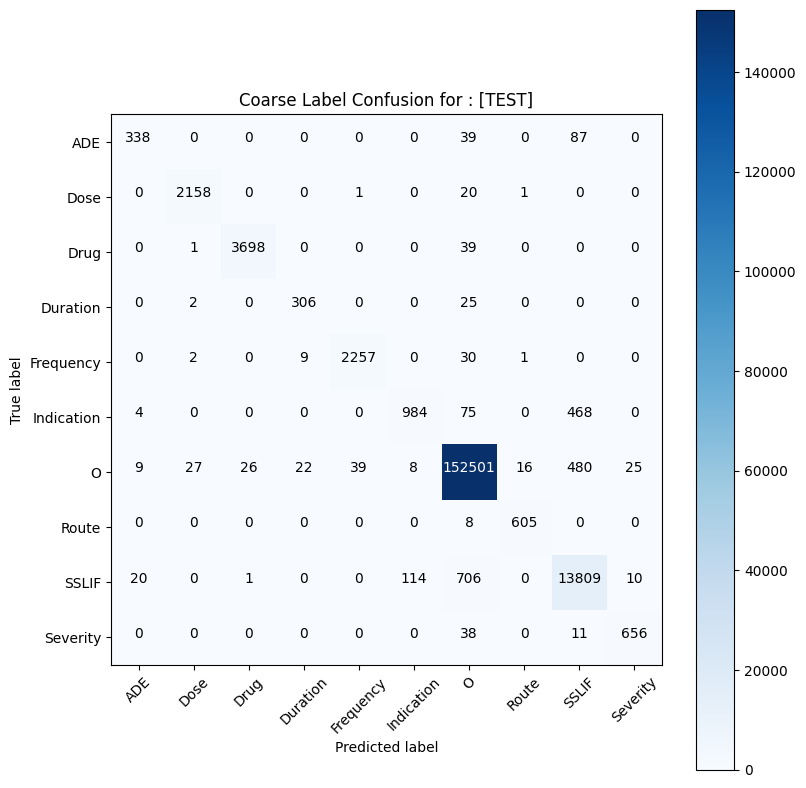

In [30]:
if SINGLE_FOLD_FIT:
    sorted_coarse_no_filter = list(sorted_coarse_labels)
    sorted_coarse_no_filter.append('O')
    sorted_coarse_no_filter = sorted(sorted_coarse_no_filter)
    print(sorted_coarse_no_filter)

    confusion_coarse = confusion_matrix(flatten([get_coarse_labels(x) for x in y_test]), 
                                        flatten([get_coarse_labels(x) for x in y_pred])
                                        , labels = sorted_coarse_no_filter)
    plt.figure()

    plot_confusion_matrix(confusion_coarse, classes=sorted_coarse_no_filter,
                          title='Coarse Label Confusion for : [{0}]'.format('TEST'))
    plt.show()

# Now let's try to evaluate spans just as the final BIOC evaluation will happen

In [31]:
if SINGLE_FOLD_FIT:
    evaluate_via_bioc(test_docs, crf, extractor, PREDICTION_DIR, MADE_BASE_DIR)

Total documents for evaluation : 176
Existing files removed : 176
Total prediction documents written : 176
The support, recall, precision, and f-score for Task NER-STRICT : Category Drug is 3025,0.9758677685950413,0.983016983016983,0.9794293297942933
The support, recall, precision, and f-score for Task NER-STRICT : Category Indication is 705,0.5872340425531914,0.8661087866108786,0.6999154691462384
The support, recall, precision, and f-score for Task NER-STRICT : Category Frequency is 933,0.9431939978563773,0.9282700421940928,0.9356725146198831
The support, recall, precision, and f-score for Task NER-STRICT : Category Severity is 620,0.8483870967741935,0.9443447037701975,0.8937977909940527
The support, recall, precision, and f-score for Task NER-STRICT : Category Dose is 1072,0.9244402985074627,0.9538017324350336,0.9388915206063476
The support, recall, precision, and f-score for Task NER-STRICT : Category Duration is 174,0.8333333333333334,0.8192090395480226,0.8262108262108262
The suppo

# Error Analysis
Let's take a look at some cases of opportunities for improvement

In [32]:
def create_sentence_string(tokens, tags):
    tagged_string = ''
    for i in range(len(tokens)):
        token = tokens[i]
        tag = tags[i]
        tagged_string += token
        if tag != 'O':
            tagged_string += '/{0}'.format(tag)
            
        tagged_string += ' '
        
    return tagged_string.strip()

if SINGLE_FOLD_FIT:

    # set up a map to collect errors
    test_fp_map = {}
    test_fn_map = {}
    test_tp_map = {}
    for label in labels:
        label = label.replace('B-', '').replace('I-', '')
        test_fp_map[label] = set()
        test_fn_map[label] = set()
        test_tp_map[label] = set()

    # then gather the errors by label
    for i in range(len(y_test)):
        sentence_tokens = X_test[i]
        sentence_gold = y_test[i]
        sentence_pred = y_pred[i]
        sentence_gold = [x.replace('B-', '').replace('I-', '') for x in sentence_gold]
        sentence_pred = [x.replace('B-', '').replace('I-', '') for x in sentence_pred]
        sentence_gold_str = 'GOLD : ' + create_sentence_string(sentence_tokens, sentence_gold)
        sentence_pred_str = 'PRED : ' + create_sentence_string(sentence_tokens, sentence_pred)
        #print(sentence_gold_str)
        #print(sentence_pred_str)

        pair = tuple((sentence_gold_str, sentence_pred_str))

        for tag_idx in range(len(sentence_gold)):
            pred_tag = sentence_pred[tag_idx]
            gold_tag = sentence_gold[tag_idx]

            if pred_tag == gold_tag:
                if pred_tag != 'O':
                    test_tp_map[pred_tag].add(pair)
            else:
                if pred_tag != 'O':
                    test_fp_map[pred_tag].add(pair)
                if gold_tag != 'O':
                    test_fn_map[gold_tag].add(pair)

        #break

    print('Total TP examples : {}'.format(np.sum([len(test_tp_map[tag]) for tag in test_tp_map.keys()])))
    print('Total FP examples : {}'.format(np.sum([len(test_fp_map[tag]) for tag in test_fp_map.keys()])))
    print('Total FN examples : {}'.format(np.sum([len(test_fn_map[tag]) for tag in test_fn_map.keys()])))

Total TP examples : 7474
Total FP examples : 647
Total FN examples : 766


In [41]:
def print_error_comparisons(pairs_set, error_type):
    print('**************')
    print(error_type)
    for pair in pairs_set:
        print(pair[0])
        print(pair[1])
        print('')
    print('**************')

In [42]:
PRINT_ERROR_COMPARISONS = False

In [43]:
# Let's enumerate opportunities
if PRINT_ERROR_COMPARISONS:
    print_error_comparisons(test_fn_map['ADE'], 'False Negatives')

In [44]:
# Let's enumerate opportunities
if PRINT_ERROR_COMPARISONS:
    print_error_comparisons(test_fp_map['ADE'], 'False Positives')

In [45]:
# Let's enumerate opportunities
if PRINT_ERROR_COMPARISONS:
    print_error_comparisons(test_fn_map['Indication'], 'False Negatives')

In [46]:
# Let's enumerate opportunities
if PRINT_ERROR_COMPARISONS:
    print_error_comparisons(test_fp_map['Indication'], 'False Positives')

In [47]:
# Let's enumerate opportunities
if PRINT_ERROR_COMPARISONS:
    print_error_comparisons(test_fn_map['SSLIF'], 'False Negatives')

In [48]:
# Let's enumerate opportunities
if PRINT_ERROR_COMPARISONS:
    print_error_comparisons(test_fp_map['SSLIF'], 'False Positives')

# Examining top features

In [49]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

TOP_N_FEATURES = 50 

if SINGLE_FOLD_FIT:
        
    print("Top positive:")
    print_state_features(Counter(crf.state_features_).most_common(TOP_N_FEATURES))

    print("\nTop negative:")
    print_state_features(Counter(crf.state_features_).most_common()[-1 * TOP_N_FEATURES:])

Top positive:
4.410975 O        -1wlow:bos
3.866964 O        0wlow:none
3.844552 O        0wlow:hemodialysis
3.810031 B-Severity 0c[-3:]:/10
3.650360 O        0wlow:dialysis
3.602826 B-Indication 0wlow:prophylactic
3.597112 B-Drug   0c[-3:]:ole
3.399577 O        0wlow:diagnosis
3.339877 B-Drug   0c[-2:]:ol
3.285236 B-Drug   0wlow:pamidronate
3.285236 B-Drug   0word[:3]:pam
3.234729 B-Drug   0wlow:prednisone
3.222200 B-SSLIF  0wlow:hemorrhage
3.198303 O        0wlow:male
3.154704 B-SSLIF  0c[-3:]:aly
3.142686 O        0wlow:healthy
3.023472 B-Drug   0word[:3]:rit
2.997788 B-Drug   0wlow:reclast
2.903429 B-Drug   0wlow:thalidomide
2.903179 B-SSLIF  0wlow:pale
2.886739 B-Frequency 0c[:2]:q.
2.869048 B-SSLIF  0word[:3]:obe
2.824536 B-Drug   0word[:3]:ant
2.792359 B-Drug   0c[-3:]:rin
2.757828 B-Drug   0wlow:revlimid
2.730777 B-Drug   0c[-3:]:ron
2.724780 B-SSLIF  0wlow:died
2.702157 B-Severity 0c[-2:]:10
2.701302 B-Dose   0c[-2:]:mg
2.697815 B-SSLIF  0c[-3:]:ias
2.681826 B-SSLIF  -1word[:3

# Optionally run a full parameter search

In [50]:
%%time

PERFORM_PARAM_SEARCH = True

MULTICORE_PARAM_FOLDS = 5
# each fold can take 2 to 2.5 GB, so with the parent process we can only fit 4 folds into 16 GB
MULTICORE_PARAM_JOBS = 1
MULTICORE_PARAM_ITERATIONS = 3

rs = None

if PERFORM_PARAM_SEARCH:
    print('Starting Param Search...')
    
    params_space = {
        #'c1' : expon(scale = 0.5), # search range in sklearn_crfsuite example
        #'c2' : expon(scale = 0.05) 
        'c1' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 5.0, 10.0],
        'c2' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 5.0, 10.0]
    }
    
    f1_scorer = make_scorer(metrics.flat_f1_score, average = 'weighted', labels = labels)
    
    rs = RandomizedSearchCV(crf, params_space, 
                                   cv = MULTICORE_PARAM_FOLDS,
                                   verbose = 1,
                                   n_jobs = MULTICORE_PARAM_JOBS,
                                   n_iter = MULTICORE_PARAM_ITERATIONS,
                                   random_state = int(time.time() % 100),
                                   scoring = f1_scorer)

    rs.fit(X_train_feat, y_train)

    print('Best params : {}'.format(rs.best_params_))
    print('Best CV score : {}'.format(rs.best_score_))
    print('model size : {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

    best_model = rs.best_estimator_

    validation_start_time = time.time()

    print('Now performing additional validation')

    #f1 = _score(estimator, X_test, y_test, scorer, is_multimetric=False)
    test_pred_unflattened = best_model.predict(X_test_feat)

    print('**********')
    #print('AUC : {0}'.format(auc))
    #print('TEST F1 : {0}'.format(f1))
    #print('TEST Precision : {0}'.format(precision))
    #print('TEST Recall : {0}'.format(recall))

    print('Report for CV (TRAIN):')
    # use these flattened versions
    print(sklearn_crfsuite.metrics.flat_classification_report(
                    [get_coarse_labels(x) for x in y_train], 
                     [get_coarse_labels(x) for x in best_model.predict(X_train_feat)],
                    labels = sorted_coarse_labels, digits = 3))

    print('Report for CV (TEST):')
    # use these flattened versions
    print(sklearn_crfsuite.metrics.flat_classification_report(
                    [get_coarse_labels(x) for x in y_test], 
                     [get_coarse_labels(x) for x in test_pred_unflattened],
                    labels = sorted_coarse_labels, digits = 3))

    print('Total time for validation : {} seconds'.format(time.time() - validation_start_time))

Starting Param Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [51]:
# Plotting of params from RandomSearch...
if rs is not None:
    print('Preparing plot of RandomSearch results...')
    _x = [s.parameters['c1'] for s in rs.grid_scores_]
    _y = [s.parameters['c2'] for s in rs.grid_scores_]
    _c = [s.mean_validation_score for s in rs.grid_scores_]

    fig = plt.figure()
    fig.set_size_inches(12, 12)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('C1')
    ax.set_ylabel('C2')
    ax.set_title("Randomized Hyperparameter Search CV Results (F1) (min={:0.3}, max={:0.3})".format(
        min(_c), max(_c)
    ))

    ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

    print("Dark blue => {:0.4} F1, dark red => {:0.4} F1".format(min(_c), max(_c)))

Preparing plot of RandomSearch results...


AttributeError: 'RandomizedSearchCV' object has no attribute 'grid_scores_'

# Finally, if enabled, we will write out the appropriate predictions based on the features and the run for final submission for the challenge

In [34]:
if WRITE_TEST_PREDICTIONS:
    print('Preparing to write HOLD OUIT predictions...')
    TEST_PRED_BASE_DIR = 'final_predictions'
    TEST_SOURCE_SUBDIR = 'RedCap_Notes_905'
    TEST_SOURCE_DIR = r'{0}\{1}'.format(MADE_ALL_SETS_BASE_DIR, TEST_SOURCE_SUBDIR)
    test_pred_run_subdir = r'{0}/Task5RedCap-{1}-{2}'.format(TEST_PRED_BASE_DIR, FEATURE_SET, RUN_NAME)
    print('Prepping to write predictions to : {}'.format(test_pred_run_subdir))
    
    print('Reading unlabeled source files from : {}'.format(TEST_SOURCE_DIR))
    holdout_test_docs = read_made_data(TEST_SOURCE_DIR, made_tokenizer)

    print('Total Final Holdout Docs : {}'.format(len(holdout_test_docs)))
    
    # pass None as the MADE base dir since there are no gold labels for comparison
    evaluate_via_bioc(holdout_test_docs, crf, extractor, test_pred_run_subdir, None)
    
    print('DONE writing out HOLDOUT predictions')

Preparing to write HOLD OUIT predictions...
Prepping to write predictions to : final_predictions/Task5RedCap-Standard-Run1
Reading unlabeled source files from : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE\RedCap_Notes_905
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE\RedCap_Notes_905\annotations\0403702.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE\RedCap_Notes_905\annotations\0403702_1.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE\RedCap_Notes_905\annotations\0403702_10.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE\RedCap_Notes_905\annotations\0403702_100.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\De

# NOTE : The cell before is for the ACTUAL finally released test set (released after the challenge and workshop were both completed)

In [ ]:
if WRITE_TEST_PREDICTIONS:
    print('Preparing to write RELEASED TEST SET predictions...')
    TEST_SET_PRED_BASE_DIR = 'test_set_predictions'
    TEST_SET_SOURCE_SUBDIR = 'made_test_data'
    TEST_SET_SOURCE_DIR = r'{0}/{1}'.format(MADE_ALL_SETS_BASE_DIR, TEST_SET_SOURCE_SUBDIR)
    test_set_pred_run_subdir = r'{0}/Task1-{1}-{2}'.format(TEST_SET_PRED_BASE_DIR, FEATURE_SET, RUN_NAME)
    print('Prepping to write predictions to : {}'.format(test_set_pred_run_subdir))
    
    print('Reading TEST SET source files from : {}'.format(TEST_SET_SOURCE_DIR))
    test_set_docs = read_made_data(TEST_SET_SOURCE_DIR, made_tokenizer)

    print('Total Final TEST SET Docs : {}'.format(len(test_set_docs)))
    
    # pass None as the MADE base dir TO ASSUME that there are no gold labels for comparison
    evaluate_via_bioc(test_set_docs, crf, extractor, test_set_pred_run_subdir, None)
    
    print('DONE writing out TEST SET predictions')

Preparing to write RELEASED TEST SET predictions...
Prepping to write predictions to : test_set_predictions/Task1-Standard-Run1
Reading TEST SET source files from : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_1.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_10.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_100.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_143.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_144.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_145.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_146.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_147.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_148.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_219.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_22.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_220.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_221.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_222.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_223.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_303.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_304.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_305.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_306.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_307.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_308.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_352.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_353.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_354.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_355.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_356.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_357.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_415.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_416.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_417.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_418.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_419.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_42.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_465.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_466.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_467.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_468.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_469.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_47.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_534.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_535.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_536.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_54.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_55.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\1958615_56.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\O

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_121.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_122.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_123.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_124.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_125.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_126.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_20.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_200.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_201.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_202.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_203.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_204.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_276.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_277.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_278.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_279.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_28.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_280.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_354.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_355.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_356.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_357.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_358.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_359.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_404.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_405.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_406.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_407.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_408.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_409.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_51.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_52.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_53.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_54.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_55.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\2605375_56.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneD

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3084966_13.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3084966_130.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3084966_131.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3084966_132.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3084966_133.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3084966_134.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_1.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_10.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_100.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_101.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_102.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_103.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\O

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_151.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_152.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_153.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_154.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_155.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_156.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_228.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_229.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_23.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_230.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_231.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_232.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_317.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_318.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_319.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_32.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_320.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_321.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_364.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_365.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_366.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_367.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_368.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_369.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_425.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_426.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_427.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_428.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_429.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_43.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_497.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_498.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_499.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_5.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_50.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_500.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\O

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_550.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_551.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_552.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_553.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_554.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_555.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_634.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_635.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_636.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_637.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_638.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_639.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_691.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_692.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_693.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_694.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_695.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\3095197_696.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_136.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_137.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_138.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_139.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_14.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_140.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_21.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_22.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_23.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_24.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_25.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_26.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneD

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_81.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_82.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_83.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_84.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_85.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\6441215_86.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneD

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_141.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_142.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_143.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_144.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_145.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_146.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_27.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_28.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_29.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_3.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_30.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_31.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_82.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_83.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_84.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_85.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_86.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65268056_87.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_139.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_14.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_140.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_141.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_142.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_143.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_208.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_209.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_21.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_210.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_211.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_212.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_41.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_42.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_43.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_44.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_45.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_46.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_92.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_93.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_94.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_95.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_96.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65589160_97.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_173.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_174.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_175.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_176.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_177.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_178.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_71.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_72.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_73.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_74.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_75.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65637976_76.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_146.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_147.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_148.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_149.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_15.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_150.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_216.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_217.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_218.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_219.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_22.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_220.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_58.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_59.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_6.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_60.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_61.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\65642140_62.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_110.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_111.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_112.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_113.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_114.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_115.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_170.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_171.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_172.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_173.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_174.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_175.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_50.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_51.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_52.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_53.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_54.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\66956320_55.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_102.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_103.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_104.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_105.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_106.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_107.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_159.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_16.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_160.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_161.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_162.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_163.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_88.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_89.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_9.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_90.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_91.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67136296_92.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_150.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_151.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_152.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_153.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_154.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_155.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_218.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_219.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_22.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_220.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_221.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_222.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_3.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_30.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_300.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_301.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_31.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_32.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa40

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_93.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_94.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_95.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_96.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_97.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67137004_98.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_153.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_154.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_155.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_156.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_157.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_158.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_226.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_227.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_228.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_229.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_23.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_230.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_294.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_295.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_296.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_297.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_298.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_299.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_82.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_83.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_84.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_85.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_86.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\67546048_87.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\68679748_18.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\68679748_19.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\68679748_2.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\68679748_20.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\68679748_21.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\68679748_22.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_101.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_102.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_103.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_104.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_105.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_106.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_160.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_161.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_162.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_163.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_164.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_165.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_208.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_209.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_21.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_210.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_211.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_212.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_80.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_81.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_82.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_83.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_84.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\69091084_85.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_128.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_129.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_13.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_130.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_131.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_132.txt.bioc.xml
No BIOC annotations for file : C:\Users\a

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_180.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_181.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_182.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_183.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_184.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_185.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_243.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_244.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_245.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_246.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_247.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_248.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_291.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_292.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_293.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_294.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_295.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_296.txt.bioc.xml
No BIOC annotations for file : C:\Users\

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_45.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_46.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_47.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_48.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_49.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_5.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\72264124_99.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_1.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_10.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_100.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_101.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDr

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_162.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_163.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_164.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_165.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_166.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_167.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_234.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_235.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_236.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_237.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_238.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_239.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_286.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_287.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_288.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_289.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_29.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_290.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_339.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_34.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_340.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_341.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_342.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_343.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_40.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_400.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_401.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_402.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_403.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_404.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_90.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_91.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_92.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_93.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_94.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9039233_95.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneD

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_145.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_146.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_147.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_148.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_149.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_15.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_192.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_193.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_194.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_195.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_196.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_197.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_249.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_25.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_250.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_251.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_252.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_253.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_313.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_314.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_315.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_316.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_317.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_318.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_386.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_387.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_388.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_389.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_39.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_390.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_459.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_46.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_460.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_461.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_462.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_463.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_76.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_77.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_78.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_79.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_8.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9198708_80.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDr

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_18.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_19.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_2.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_20.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_21.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_22.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDr

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_68.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_69.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_7.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_70.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_71.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9532443_72.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDr

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_161.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_162.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_163.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_164.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_165.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_166.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_246.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_247.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_248.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_249.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_25.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_250.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_306.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_307.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_308.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_309.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_31.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_310.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_85.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_86.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_87.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_88.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_89.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9932982_9.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDr

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_148.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_149.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_15.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_150.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_151.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_152.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_209.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_21.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_210.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_211.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_212.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_213.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_263.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_264.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_265.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_266.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_267.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_268.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_311.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_312.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_313.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_314.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_315.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_316.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa402

No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_52.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_53.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_54.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_55.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_56.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneDrive - Weill Cornell Medicine\Desktop\UMass MADE\UMass_MADE/WCM-notes\annotations\9982185_57.txt.bioc.xml
No BIOC annotations for file : C:\Users\aaa4026\OneD

In [62]:
PREDICT_ON_ALL_GOLD_DATA = True
if PREDICT_ON_ALL_GOLD_DATA:
    print('Preparing to write ALL GOLD predictions...')
    GOLD_PRED_BASE_DIR = 'all_gold_predictions'

    print('Total Gold Prediction Docs : {}'.format(len(train_docs + test_docs)))
    
    # pass None as the MADE base dir since there are no gold labels for comparison
    evaluate_via_bioc(train_docs + test_docs, crf, extractor, GOLD_PRED_BASE_DIR, None)
    
    print('DONE writing out ALL GOLD predictions')

Preparing to write ALL GOLD predictions...
Total Gold Prediction Docs : 876
Total documents for evaluation : 876
Existing files removed : 0
Total prediction documents written : 876
DONE writing out ALL GOLD predictions
